In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset,DataLoader

# !pip install torchmetrics
import torchmetrics

In [58]:
df = pd.read_csv('/content/fmnist.csv')     # change this to ur file path
df.shape

(6000, 785)

In [59]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,72,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,2,0,0,210,228,228,233,0,0,0,0,0,0,0,0,0,31,81,133,184,201,190,117,0,0,2,1,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,43,117,34,15,24,33,117,80,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,51,144,152,...,157,158,161,148,159,58,0,6,0,0,0,0,0,0,0,0,0,4,0,60,143,143,148,146,152,152,148,148,147,145,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,0,0,0,2,0,33,114,37,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,11,17,13,13,11,10,7,5,5,5,7,0,0,0,1,0,0,41,69,88,86,94,106,114,118,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,0,2,0,58,145,114,10,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,...,165,153,155,134,143,172,215,62,0,0,0,0,0,0,0,0,10,190,178,194,209,211,209,205,211,215,213,217,225,228,213,203,174,151,188,10,0,0,0,0


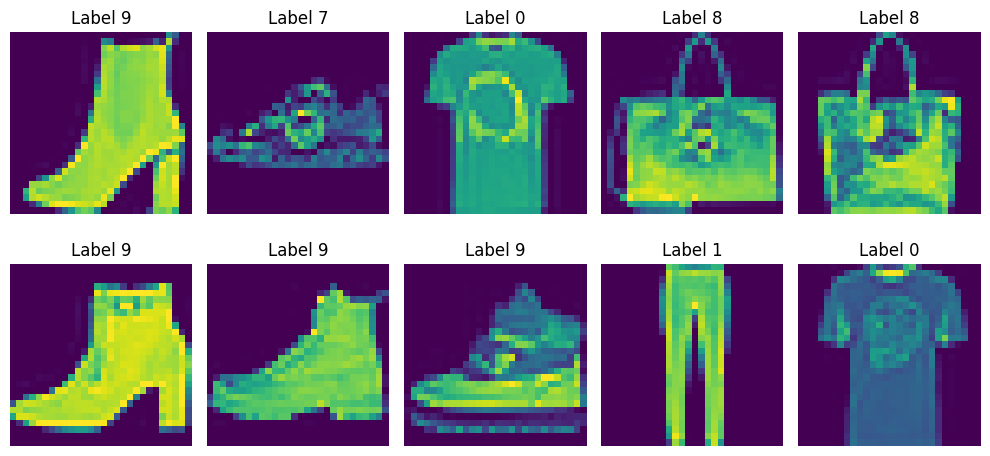

In [60]:
# plotting first 10 images
fig,axes =plt.subplots(2,5,figsize=(10,5))

for i,ax in enumerate(axes.flat):
  img = df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f'Label {df.iloc[i,0]}')

plt.tight_layout()
plt.show()


In [61]:
# feats & labels

X = df.drop('label',axis=1)
y = df['label']

In [62]:
# train-test split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=38)

In [63]:
# scaling

X_train = X_train/255.0
X_test = X_test/255.0

# max pixel value = 255.0
# pixel range 0 to 255
# after scaling all values range 0 to 1

In [64]:
# custom Datset class

class CustomDataset(Dataset):
  def __init__(self,feats,labels):
    self.feats = torch.tensor(feats.values,dtype=torch.float32)
    self.labels = torch.tensor(labels.values,dtype=torch.long)

  def __len__(self):
    return len(self.feats)

  def __getitem__(self,idx):
    return self.feats[idx],self.labels[idx]

In [65]:
# instances for CustomDataset
train_dataset = CustomDataset(X_train,y_train)
test_dataset = CustomDataset(X_test,y_test)

In [66]:
# DataLoader

train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [67]:
# Defining ANN

class SimpleANN(nn.Module):

  def __init__(self,input_size):
    super().__init__()

    self.network = nn.Sequential(
        nn.Linear(input_size,128),      # H1 layer : 784 i/p , 128 neurons
        nn.ReLU(),
        nn.Linear(128,64),              # H2 layer : 128 i/p , 64 neurons
        nn.ReLU(),
        nn.Linear(64,10)                # output layer : 64 i/p , 10 neurons since '0-9 labels'
    )

  def forward(self,input):
    out = self.network(input)
    return out

In [73]:
learning_rate = 0.01

epochs = 100

loss_fn = nn.CrossEntropyLoss()

In [74]:
# model instance

model = SimpleANN(X_train.shape[1])

optimizer = optim.Adam(model.parameters(),lr=learning_rate)

In [75]:
# training pipeline

for epoch in range(epochs):
  total_loss = 0

  for batch_feats,batch_labels in train_dataloader:

    y_pred = model(batch_feats)

    loss = loss_fn(y_pred,batch_labels)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch : {epoch+1} , Loss : {total_loss/len(train_dataloader)}")

Epoch : 1 , Loss : 0.8491459349791209
Epoch : 2 , Loss : 0.5862278123696645
Epoch : 3 , Loss : 0.5458072297771772
Epoch : 4 , Loss : 0.4851769608259201
Epoch : 5 , Loss : 0.47968765708307426
Epoch : 6 , Loss : 0.4548099478085836
Epoch : 7 , Loss : 0.4541285016139348
Epoch : 8 , Loss : 0.4045355621476968
Epoch : 9 , Loss : 0.3698630895713965
Epoch : 10 , Loss : 0.37701938100159166
Epoch : 11 , Loss : 0.36996195072929067
Epoch : 12 , Loss : 0.3640187212328116
Epoch : 13 , Loss : 0.3626277789473534
Epoch : 14 , Loss : 0.3259003693486253
Epoch : 15 , Loss : 0.3496094956994057
Epoch : 16 , Loss : 0.3297611488898595
Epoch : 17 , Loss : 0.31030989314119023
Epoch : 18 , Loss : 0.29629680717984835
Epoch : 19 , Loss : 0.3006926759084066
Epoch : 20 , Loss : 0.3013380546371142
Epoch : 21 , Loss : 0.28685056112706664
Epoch : 22 , Loss : 0.2977009764313698
Epoch : 23 , Loss : 0.3175442373007536
Epoch : 24 , Loss : 0.2627708290765683
Epoch : 25 , Loss : 0.26923075146973136
Epoch : 26 , Loss : 0.24680

In [76]:
from torchmetrics.classification import MulticlassAccuracy

metrics = MulticlassAccuracy(num_classes=10)

# num_classes = output layer neurons

In [77]:
# model evaluation

model.eval()

with torch.no_grad():

    for batch_feats, batch_labels in test_dataloader:

        y_pred = model(batch_feats)

        metrics.update(y_pred, batch_labels)

total_accuracy = metrics.compute()
print(f"Test Accuracy: {total_accuracy:.2f}")

metrics.reset()

Test Accuracy: 0.81
